# Exploratory Data Analysis

### Goal
- Brief Exploratory Data Analysis
- Train/Test Distribution
- Image Dataset Standardization
- Brief Feature Study

### Discussion
- Maybe adding the neighbors type from latitude-longitude as tabular data to the NN helps
- Year could help to discriminate the most unbalanced dataclass

### Notes
- Train and Test year is same distribution

### Imports

In [1]:
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree

import torch

from tqdm import tqdm

from PIL import Image
from torchvision import transforms

import seaborn as sns

from scipy.special import softmax

### Data

In [2]:
DATA_PATH = 'data/raw/'

In [3]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH +'test.csv')

print(f'train {train.shape} test {test.shape}')
train.head()

train (1714, 5) test (635, 4)


,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


In [4]:
test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png


### Year

Is the same on train and test?

In [5]:
print(f'{train.year.min()} {train.year.max()} {test.year.min()} {test.year.max()}')

2001 2016 2001 2016


<AxesSubplot: ylabel='Frequency'>

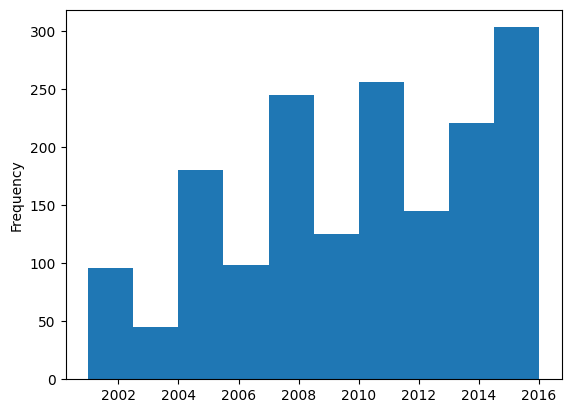

In [6]:
train.year.plot.hist()

<AxesSubplot: ylabel='Frequency'>

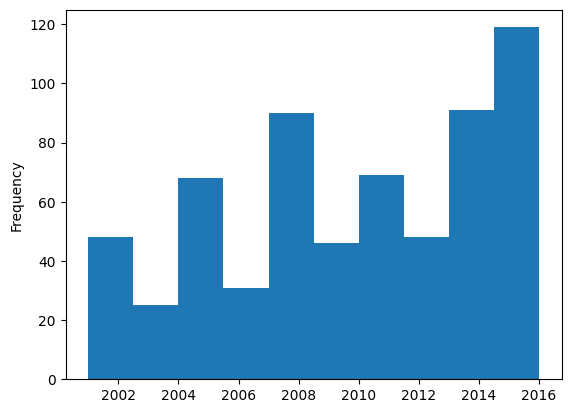

In [7]:
test.year.plot.hist()

<AxesSubplot: xlabel='year', ylabel='count'>

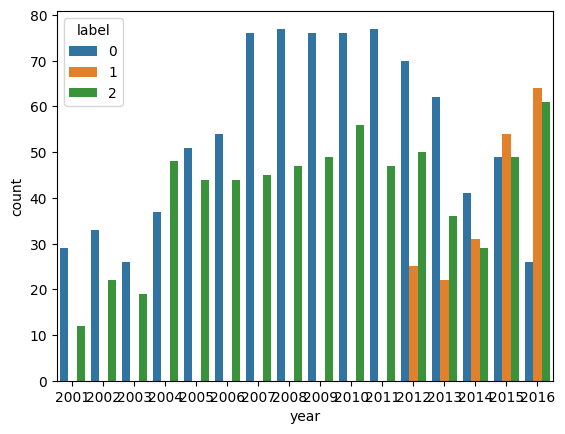

In [8]:
# This is bab, is I use it could be highly biased, no label 1 from 2012
sns.countplot(data=train, x='year', hue='label')

### Train Label Disctribution

In [9]:
train.label.value_counts(normalize=True)

0    0.501750
2    0.383897
1    0.114352
Name: label, dtype: float64

### Image Dataset Distribution

In [10]:
# Calculate Image Dataset Mean and Standard Deviation per channel

IMAGE_SIZE = 240

images = train.example_path.tolist() + test.example_path.tolist()

# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor()])

# loop through images
for image_path in tqdm(images):
    image = Image.open(DATA_PATH + image_path)
    inputs = transform(image)
    psum += inputs.sum(axis = (1,2))
    psum_sq += (inputs ** 2).sum((1,2))
    
# pixel count
count = len(images) * IMAGE_SIZE * IMAGE_SIZE

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 2349/2349 [00:26<00:00, 88.47it/s]

mean: tensor([0.0871, 0.1189, 0.0597])
std:  tensor([0.0502, 0.0434, 0.0393])


### Latitude/Longitude (KNN Neightbours)

The idea here is, are neightbours label related? 

In [11]:
lat = np.expand_dims(train.latitude.values, 1)
long = np.expand_dims(train.longitude.values, 1)

X = np.concatenate((lat, long), axis = 1)

spatialTree = cKDTree(X)

In [12]:
K = 5 # number of neighbours

context = []
for t in train.itertuples():
    k_distance, k_idx = spatialTree.query((t.longitude,t.latitude), k=K) # get neighbours and distances
    if K == 1:
        k_distance, k_idx = [k_distance], [k_idx]
    # Create and add context from closest neighbours
    tmp = np.zeros(3)
    for n, distance in zip(k_idx, k_distance):
        #if distance < 500: ????? 
        tmp[train.label[n]] = tmp[train.label[n]] + 1
    tmp = softmax(np.array(tmp)) # Normalization
    
    context.append([t.label, tmp[t.label]])
    
context = pd.DataFrame(context, columns = ['Label', 'NeighbourRelationship'])

In [13]:
context.head()

,Label,NeighbourRelationship
0,0,0.786986
1,2,0.106507
2,0,0.705385
3,0,0.705385
4,0,0.705385


<AxesSubplot: xlabel='Label', ylabel='NeighbourRelationship'>

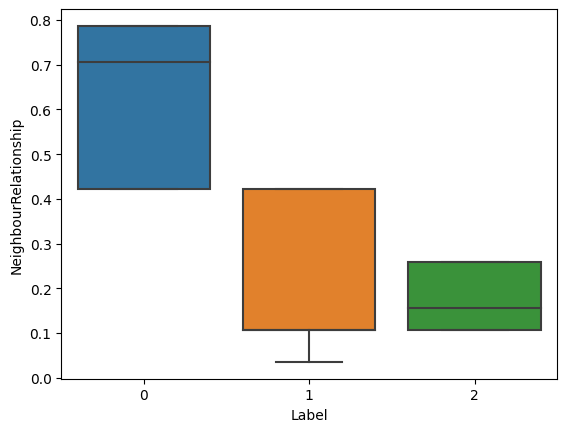

In [14]:
sns.boxplot(data=context, x="Label", y="NeighbourRelationship")